In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Activation, Dropout, Dense, LeakyReLU
from tensorflow.keras import Sequential

from tqdm import tqdm

In [2]:
file='stress_summary.csv'
dfstress=pd.read_csv(file)
dfstress.head(5)

,jobid,xcoord,ycoord,zcoord,Mises
0,model0000,1.765090,3.513055,0.0,981.961761
1,model0000,1.608500,4.252800,0.0,13.871708
2,model0000,3.140261,2.451003,0.0,1906.931213
3,model0000,2.102374,3.004073,0.0,2132.610352
4,model0000,2.719147,2.573021,0.0,2319.990723


In [3]:
df_models=pd.read_csv('model_definitions.csv')

#landing spots for stresses: stress_i
for i in range(1,51):
    df_models['Stress_'+str(i)]=''

df_models.set_index('jobid', inplace=True)
df_models.head()

,L1,L2,L3,L4,H1,R1,R2,Stress_1,Stress_2,Stress_3,...,Stress_41,Stress_42,Stress_43,Stress_44,Stress_45,Stress_46,Stress_47,Stress_48,Stress_49,Stress_50
jobid,,,,,,,,,,,,,,,,,,,,,
model0000,4.2528,5.1383,2.4272,1.6085,2.6192,1.8256,0.3057,,,,...,,,,,,,,,,
model0001,4.0728,7.0055,2.7165,2.9818,2.7783,1.3563,0.2710,,,,...,,,,,,,,,,
model0002,4.0588,5.9513,1.9989,1.9095,1.7764,2.0600,0.5268,,,,...,,,,,,,,,,
model0003,5.7358,6.3318,3.1162,3.2121,3.1042,2.6196,0.5587,,,,...,,,,,,,,,,
model0004,4.1967,6.3250,1.8852,3.0049,2.1143,2.3115,0.3814,,,,...,,,,,,,,,,


In [4]:
jobs=dfstress['jobid'].unique().tolist()
len(jobs)

1983

In [5]:
#Normalize stresses
#Iterating over jobs that ran
for job in tqdm(jobs):

    xcoords=dfstress[dfstress['jobid']==job].xcoord.to_numpy()
    ycoords=dfstress[dfstress['jobid']==job].ycoord.to_numpy()
    mises=dfstress[dfstress['jobid']==job].Mises.to_numpy()

    #90° fillet, find center and transfer to local coordinates
    cy = ycoords.max()
    ylocal=ycoords-cy

    #Normalized angle, [0, 1] starting at 9 o'clock, going to 6 o'clock ccw
    angle = np.arcsin(ylocal/ylocal.min()) / np.arcsin(ylocal/ylocal.min()).max()

    #Fit interpolator
    finterp=interpolate.interp1d(angle, mises)

    #Interpolation to regular spacing
    xnew = np.linspace(0,1,50)
    misesnorm = finterp(xnew)

    #store in dataframe
    for i in range(1,51):
        df_models.at[job,'Stress_'+str(i)]=misesnorm[i-1]

100%|██████████████████████████████████████| 1983/1983 [00:23<00:00, 86.14it/s]


In [6]:
#Prune rows for jobs that failed
failed = df_models[df_models['Stress_1']==''].index.tolist()

df_models=df_models.drop(failed)
df_models.shape

(1983, 57)

In [7]:
df_models

,L1,L2,L3,L4,H1,R1,R2,Stress_1,Stress_2,Stress_3,...,Stress_41,Stress_42,Stress_43,Stress_44,Stress_45,Stress_46,Stress_47,Stress_48,Stress_49,Stress_50
jobid,,,,,,,,,,,,,,,,,,,,,
model0000,4.2528,5.1383,2.4272,1.6085,2.6192,1.8256,0.3057,13.871708,12.334601,11.833697,...,2142.555444,2076.362907,2010.652918,1957.657394,1902.851206,1807.571588,1712.29197,1617.809542,1524.058885,1430.308228
model0002,4.0588,5.9513,1.9989,1.9095,1.7764,2.0600,0.5268,48.381531,29.893296,11.405061,...,3487.061436,3368.830228,3247.662897,3142.240701,3044.71876,2924.036535,2778.13276,2632.315934,2486.801278,2341.286621
model0003,5.7358,6.3318,3.1162,3.2121,3.1042,2.6196,0.5587,6.809675,7.094964,8.162865,...,945.498563,874.408177,803.720729,733.080011,664.532592,596.581824,548.261999,500.069637,460.380811,420.691986
model0004,4.1967,6.3250,1.8852,3.0049,2.1143,2.3115,0.3814,16.417873,13.903301,13.100347,...,2387.332013,2286.181763,2187.151339,2099.033919,2010.916499,1876.025315,1739.04928,1603.986685,1471.008113,1338.029541
model0005,3.7496,5.3787,1.6092,2.6510,1.1491,2.1404,0.6420,18.319878,15.50482,14.056624,...,2231.359845,2148.095677,2054.055926,1924.959015,1798.857229,1676.891398,1535.872943,1382.411293,1226.595146,1070.199402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
model1996,6.4775,5.3805,4.3494,1.9655,3.9761,2.1281,0.5583,9.118735,8.509167,8.356746,...,912.968679,867.907938,822.847197,772.886246,718.446405,664.006564,610.955348,561.83185,512.708352,463.584854
model1997,4.2310,6.4296,2.3587,2.1447,2.1387,1.8724,0.4823,19.906971,16.902169,14.60204,...,3199.711038,3074.152947,2962.765826,2852.479955,2731.055408,2617.113954,2506.059725,2362.782785,2212.425658,2054.983704
model1998,4.8771,7.4977,2.8507,2.4821,2.5218,2.0263,0.5801,20.419123,18.016566,16.678366,...,2842.873904,2733.588869,2622.756862,2506.627746,2396.245677,2294.127784,2178.080819,2052.614304,1924.950997,1796.799622


In [8]:
#Calculate ligament thickness

def ligament(row):
    dx = row['R1'] #L4+R1-L4
    dy = row['L1'] - row['H1']
    
    return np.sqrt(dx**2 + dy**2)


df_models['ligament'] = df_models[['L1', 'L2', 'L3', 'L4', 'H1', 'R1', 'R2']].apply(ligament, axis=1)
df_models.head()

,L1,L2,L3,L4,H1,R1,R2,Stress_1,Stress_2,Stress_3,...,Stress_42,Stress_43,Stress_44,Stress_45,Stress_46,Stress_47,Stress_48,Stress_49,Stress_50,ligament
jobid,,,,,,,,,,,,,,,,,,,,,
model0000,4.2528,5.1383,2.4272,1.6085,2.6192,1.8256,0.3057,13.871708,12.334601,11.833697,...,2076.362907,2010.652918,1957.657394,1902.851206,1807.571588,1712.29197,1617.809542,1524.058885,1430.308228,2.449789
model0002,4.0588,5.9513,1.9989,1.9095,1.7764,2.0600,0.5268,48.381531,29.893296,11.405061,...,3368.830228,3247.662897,3142.240701,3044.71876,2924.036535,2778.13276,2632.315934,2486.801278,2341.286621,3.074565
model0003,5.7358,6.3318,3.1162,3.2121,3.1042,2.6196,0.5587,6.809675,7.094964,8.162865,...,874.408177,803.720729,733.080011,664.532592,596.581824,548.261999,500.069637,460.380811,420.691986,3.713169
model0004,4.1967,6.3250,1.8852,3.0049,2.1143,2.3115,0.3814,16.417873,13.903301,13.100347,...,2286.181763,2187.151339,2099.033919,2010.916499,1876.025315,1739.04928,1603.986685,1471.008113,1338.029541,3.111177
model0005,3.7496,5.3787,1.6092,2.6510,1.1491,2.1404,0.6420,18.319878,15.50482,14.056624,...,2148.095677,2054.055926,1924.959015,1798.857229,1676.891398,1535.872943,1382.411293,1226.595146,1070.199402,3.368073


In [9]:
#Additional feature(s)
#Length from fillet to free end
df_models['L5']=df_models['L2']-df_models['L4']-df_models['R1']

#L3/L1 ratio
df_models['L3L1']=df_models['L3']/df_models['L1']

#R1/L1 ratio
df_models['R1L1']=df_models['R1']/df_models['L1']

#L3**2
#df_models['L3xL3']=df_models['L3']*df_models['L3']

df_models.head()

,L1,L2,L3,L4,H1,R1,R2,Stress_1,Stress_2,Stress_3,...,Stress_45,Stress_46,Stress_47,Stress_48,Stress_49,Stress_50,ligament,L5,L3L1,R1L1
jobid,,,,,,,,,,,,,,,,,,,,,
model0000,4.2528,5.1383,2.4272,1.6085,2.6192,1.8256,0.3057,13.871708,12.334601,11.833697,...,1902.851206,1807.571588,1712.29197,1617.809542,1524.058885,1430.308228,2.449789,1.7042,0.570730,0.429270
model0002,4.0588,5.9513,1.9989,1.9095,1.7764,2.0600,0.5268,48.381531,29.893296,11.405061,...,3044.71876,2924.036535,2778.13276,2632.315934,2486.801278,2341.286621,3.074565,1.9818,0.492485,0.507539
model0003,5.7358,6.3318,3.1162,3.2121,3.1042,2.6196,0.5587,6.809675,7.094964,8.162865,...,664.532592,596.581824,548.261999,500.069637,460.380811,420.691986,3.713169,0.5001,0.543290,0.456710
model0004,4.1967,6.3250,1.8852,3.0049,2.1143,2.3115,0.3814,16.417873,13.903301,13.100347,...,2010.916499,1876.025315,1739.04928,1603.986685,1471.008113,1338.029541,3.111177,1.0086,0.449210,0.550790
model0005,3.7496,5.3787,1.6092,2.6510,1.1491,2.1404,0.6420,18.319878,15.50482,14.056624,...,1798.857229,1676.891398,1535.872943,1382.411293,1226.595146,1070.199402,3.368073,0.5873,0.429166,0.570834


In [10]:
#Prepare lists of input and output columns
columns = df_models.columns.tolist()

inputcols=[]
outputcols=[]
for col in columns:
    if 'Stress' in col:
        outputcols.append(col)
    else:
        inputcols.append(col)
        

In [11]:
#Extract from dataframe to arrays
inputs = df_models[inputcols].to_numpy().astype(np.float32)
outputs = df_models[outputcols].to_numpy().astype(np.float32)

In [12]:
#Test train split w/ 80% training, 10% validation, 10% test
inputs_train, inputs_remain, outputs_train, outputs_remain = train_test_split(inputs, outputs, test_size=0.2, random_state=19)
inputs_test, inputs_val, outputs_test, outputs_val = train_test_split(inputs_remain, outputs_remain, test_size=0.5, random_state=37)

In [13]:
#Scale to range [0,1] on Train data, transform Val and Test to prevent leakage
#Inputs
in_scaler = MinMaxScaler()
inputs_train = in_scaler.fit_transform(inputs_train)
inputs_test = in_scaler.transform(inputs_test)
inputs_val = in_scaler.transform(inputs_val)

#Outputs
out_scaler = MinMaxScaler()
outputs_train = out_scaler.fit_transform(outputs_train)
outputs_test = out_scaler.transform(outputs_test)
outputs_val = out_scaler.transform(outputs_val)

In [14]:
#Input, output dimensions 
inputs_train.shape[1], outputs_train.shape[1]

(11, 50)

In [15]:
#Neural Network construction
input_size = inputs_train.shape[1]
output_size = outputs_train.shape[1]

#Number of Neurons in hidden layers (multiplier may be applied)
n_neurons=512

#Leaky activation function, if needed
leaky=LeakyReLU(alpha=0.1)

#Activation
act='relu'

#Fully-connected NN with Dense layers and Softmax activation for Class probabilties
model=Sequential([
    Dense(n_neurons, activation=act, input_shape=(input_size,)),
    Dropout(0.4),
    Dense(4*n_neurons, activation=act),
    Dropout(0.4),
    Dense(8*n_neurons, activation=act),
    Dropout(0.4),
    Dense(4*n_neurons, activation=act),
    Dropout(0.4),
    Dense(n_neurons, activation=act),
    Dropout(0.4),
    Dense(output_size),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               6144      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2048)              1050624   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 4096)              8392704   
                                                                 
 dropout_2 (Dropout)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 2048)              8

In [16]:
#Define Optimizer and Loss
#Learning Rate Decay used with Adam optimizer
opt=tf.keras.optimizers.Adam(learning_rate=0.001)


#Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'accuracy'])

In [17]:
#learning rate decay
def lr_exp_decay(epoch, lr):
    
    #Start decay after specified epochs where default training rate is effective
    start=30
    if epoch > start:
        k = 0.00005
        lr=1.0 * lr * np.exp(-k*(epoch-start))
        #maintain minimum learning rate
        if lr<0.0005:
            lr=0.0005
    else:
        lr=0.001

    return lr

In [18]:
#Model callbacks
#Save best weights
checkpoint=tf.keras.callbacks.ModelCheckpoint('Stress_ANN.h5', save_best_only=True)

#Early stopping if Validation loss does not improve after specified epochs
es=tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)

#Learning rate decay - smaller steps as loss gradients are smaller
learningrate_cb = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose=1)

In [19]:
#Train the model
history=model.fit(inputs_train, outputs_train, epochs=200, 
                  validation_data=[inputs_val, outputs_val], 
                  callbacks=[checkpoint, learningrate_cb])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/200
50/50 [==============================] - 7s 124ms/step - loss: 0.0142 - mse: 0.0142 - mae: 0.0825 - accuracy: 0.1343 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0381 - val_accuracy: 0.1508 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/200
50/50 [==============================] - 6s 121ms/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0521 - accuracy: 0.1992 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0308 - val_accuracy: 0.2663 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/200
50/50 [==============================] - 5s 110ms/step - loss: 0.0048 - mse: 0.0048 - mae: 0.0484 - accuracy: 0.2119 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0471 - val_accuracy: 0.3266 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/200
50/50 [==============================] - 6s 112ms/step - loss: 0.0040 - 


Epoch 30: LearningRateScheduler setting learning rate to 0.001.
Epoch 30/200
50/50 [==============================] - 6s 122ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0332 - accuracy: 0.3619 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0228 - val_accuracy: 0.4573 - lr: 0.0010

Epoch 31: LearningRateScheduler setting learning rate to 0.001.
Epoch 31/200
50/50 [==============================] - 6s 111ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0326 - accuracy: 0.3840 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0249 - val_accuracy: 0.4221 - lr: 0.0010

Epoch 32: LearningRateScheduler setting learning rate to 0.0009999500487450556.
Epoch 32/200
50/50 [==============================] - 6s 111ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0343 - accuracy: 0.3827 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0245 - val_accuracy: 0.3819 - lr: 9.9995e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.000999850115313439.
Epoch 33/200
50/50 [======================


Epoch 57: LearningRateScheduler setting learning rate to 0.0009826032000482573.
Epoch 57/200
50/50 [==============================] - 6s 113ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0318 - accuracy: 0.4199 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0249 - val_accuracy: 0.5126 - lr: 9.8260e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0009812775553428717.
Epoch 58/200
50/50 [==============================] - 6s 113ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0318 - accuracy: 0.4395 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0230 - val_accuracy: 0.4774 - lr: 9.8128e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.0009799047259933123.
Epoch 59/200
50/50 [==============================] - 6s 113ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0311 - accuracy: 0.4401 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0240 - val_accuracy: 0.4322 - lr: 9.7990e-04

Epoch 60: LearningRateScheduler setting learning rate to 0.0009784849515802022.
E


Epoch 84: LearningRateScheduler setting learning rate to 0.0009309498570758676.
Epoch 84/200
50/50 [==============================] - 6s 113ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0313 - accuracy: 0.4596 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0244 - val_accuracy: 0.4925 - lr: 9.3095e-04

Epoch 85: LearningRateScheduler setting learning rate to 0.0009284396965714094.
Epoch 85/200
50/50 [==============================] - 6s 112ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0308 - accuracy: 0.4634 - val_loss: 9.6289e-04 - val_mse: 9.6289e-04 - val_mae: 0.0210 - val_accuracy: 0.4724 - lr: 9.2844e-04

Epoch 86: LearningRateScheduler setting learning rate to 0.0009258900219997946.
Epoch 86/200
50/50 [==============================] - 6s 112ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0296 - accuracy: 0.4729 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0211 - val_accuracy: 0.4824 - lr: 9.2589e-04

Epoch 87: LearningRateScheduler setting learning rate to 0.00092330112953

50/50 [==============================] - 6s 112ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0300 - accuracy: 0.4880 - val_loss: 9.6236e-04 - val_mse: 9.6236e-04 - val_mae: 0.0203 - val_accuracy: 0.5427 - lr: 8.5385e-04

Epoch 111: LearningRateScheduler setting learning rate to 0.0008504411722476782.
Epoch 111/200
50/50 [==============================] - 6s 112ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0301 - accuracy: 0.4596 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0222 - val_accuracy: 0.5075 - lr: 8.5044e-04

Epoch 112: LearningRateScheduler setting learning rate to 0.0008470038456785143.
Epoch 112/200
50/50 [==============================] - 6s 114ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0298 - accuracy: 0.4571 - val_loss: 9.8442e-04 - val_mse: 9.8442e-04 - val_mae: 0.0203 - val_accuracy: 0.5377 - lr: 8.4700e-04

Epoch 113: LearningRateScheduler setting learning rate to 0.0008435382237753705.
Epoch 113/200
50/50 [==============================] - 6s 113ms/step - los

50/50 [==============================] - 6s 114ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - accuracy: 0.5025 - val_loss: 9.7485e-04 - val_mse: 9.7485e-04 - val_mae: 0.0200 - val_accuracy: 0.5025 - lr: 7.5711e-04

Epoch 137: LearningRateScheduler setting learning rate to 0.000753105282467543.
Epoch 137/200
50/50 [==============================] - 6s 113ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0284 - accuracy: 0.4805 - val_loss: 9.7777e-04 - val_mse: 9.7777e-04 - val_mae: 0.0205 - val_accuracy: 0.5226 - lr: 7.5311e-04

Epoch 138: LearningRateScheduler setting learning rate to 0.0007490869143084261.
Epoch 138/200
50/50 [==============================] - 6s 114ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0283 - accuracy: 0.5006 - val_loss: 9.4928e-04 - val_mse: 9.4928e-04 - val_mae: 0.0198 - val_accuracy: 0.5276 - lr: 7.4909e-04

Epoch 139: LearningRateScheduler setting learning rate to 0.0007450527357211383.
Epoch 139/200
50/50 [==============================] - 6s 123ms/ste

50/50 [==============================] - 6s 113ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0274 - accuracy: 0.5183 - val_loss: 9.6377e-04 - val_mse: 9.6377e-04 - val_mae: 0.0199 - val_accuracy: 0.5176 - lr: 6.4901e-04

Epoch 163: LearningRateScheduler setting learning rate to 0.0006447450967313056.
Epoch 163/200
50/50 [==============================] - 6s 112ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0274 - accuracy: 0.5025 - val_loss: 8.3141e-04 - val_mse: 8.3141e-04 - val_mae: 0.0187 - val_accuracy: 0.5528 - lr: 6.4475e-04

Epoch 164: LearningRateScheduler setting learning rate to 0.0006404717421896623.
Epoch 164/200
50/50 [==============================] - 6s 113ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0272 - accuracy: 0.5025 - val_loss: 8.2339e-04 - val_mse: 8.2339e-04 - val_mae: 0.0183 - val_accuracy: 0.5176 - lr: 6.4047e-04

Epoch 165: LearningRateScheduler setting learning rate to 0.0006361949394898069.
Epoch 165/200
50/50 [==============================] - 6s 113ms/st

Epoch 188/200
50/50 [==============================] - 6s 115ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0263 - accuracy: 0.5391 - val_loss: 8.0525e-04 - val_mse: 8.0525e-04 - val_mae: 0.0176 - val_accuracy: 0.5578 - lr: 5.3786e-04

Epoch 189: LearningRateScheduler setting learning rate to 0.0005336312586678349.
Epoch 189/200
50/50 [==============================] - 6s 112ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0264 - accuracy: 0.5252 - val_loss: 7.9173e-04 - val_mse: 7.9173e-04 - val_mae: 0.0171 - val_accuracy: 0.5628 - lr: 5.3363e-04

Epoch 190: LearningRateScheduler setting learning rate to 0.0005294056964800851.
Epoch 190/200
50/50 [==============================] - 6s 113ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0264 - accuracy: 0.5025 - val_loss: 9.4205e-04 - val_mse: 9.4205e-04 - val_mae: 0.0203 - val_accuracy: 0.5226 - lr: 5.2941e-04

Epoch 191: LearningRateScheduler setting learning rate to 0.0005251873692791421.
Epoch 191/200
50/50 [==============================]

In [20]:
#Evaluate w/ test data
model.evaluate(inputs_test, outputs_test)

7/7 [==============================] - 0s 18ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0185 - accuracy: 0.5808 


[0.0012214472517371178,
 0.0012214472517371178,
 0.018545592203736305,
 0.5808081030845642]

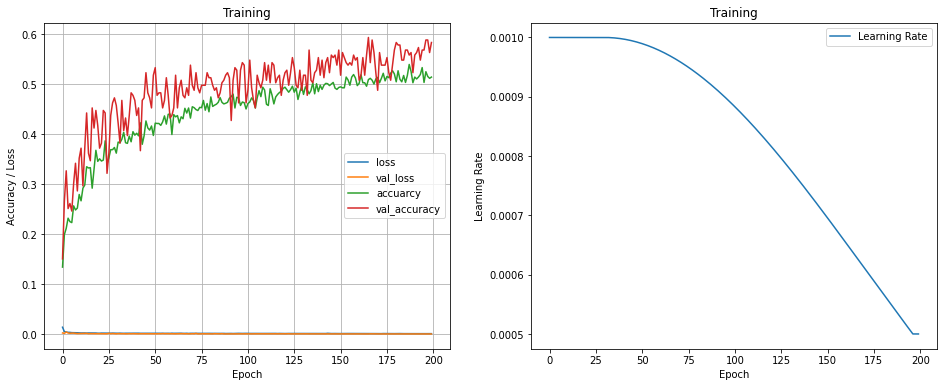

In [21]:
#Plot training accuracy and loss evolution and Learning Rate decay
#Recall, the learning rate is steady for the first n epochs, and then begins to decay exponentially.
fig, axes = plt.subplots(1,2, figsize=(16,6))
axes[0].grid(True)

l1, = axes[0].plot(history.history['loss'], label='loss')
l2, = axes[0].plot(history.history['val_loss'], label='val_loss')
l3, = axes[0].plot(history.history['accuracy'], label='accuarcy')
l4, = axes[0].plot(history.history['val_accuracy'], label='val_accuracy')
axes[0].legend(handles=[l1, l2, l3, l4])
axes[0].set_title('Training')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy / Loss')

l5, = axes[1].plot(history.history['lr'], label='Learning Rate')
axes[1].legend(handles=[l5])
axes[1].set_title('Training')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
plt.show()

In [22]:
#Generate Predictions from Test dataset
predictions=model.predict(inputs_test)

7/7 [==============================] - 0s 16ms/step


In [23]:
#Inverse Transform to FEA magnitudes
outputs_test=out_scaler.inverse_transform(outputs_test)
predictions=out_scaler.inverse_transform(predictions)

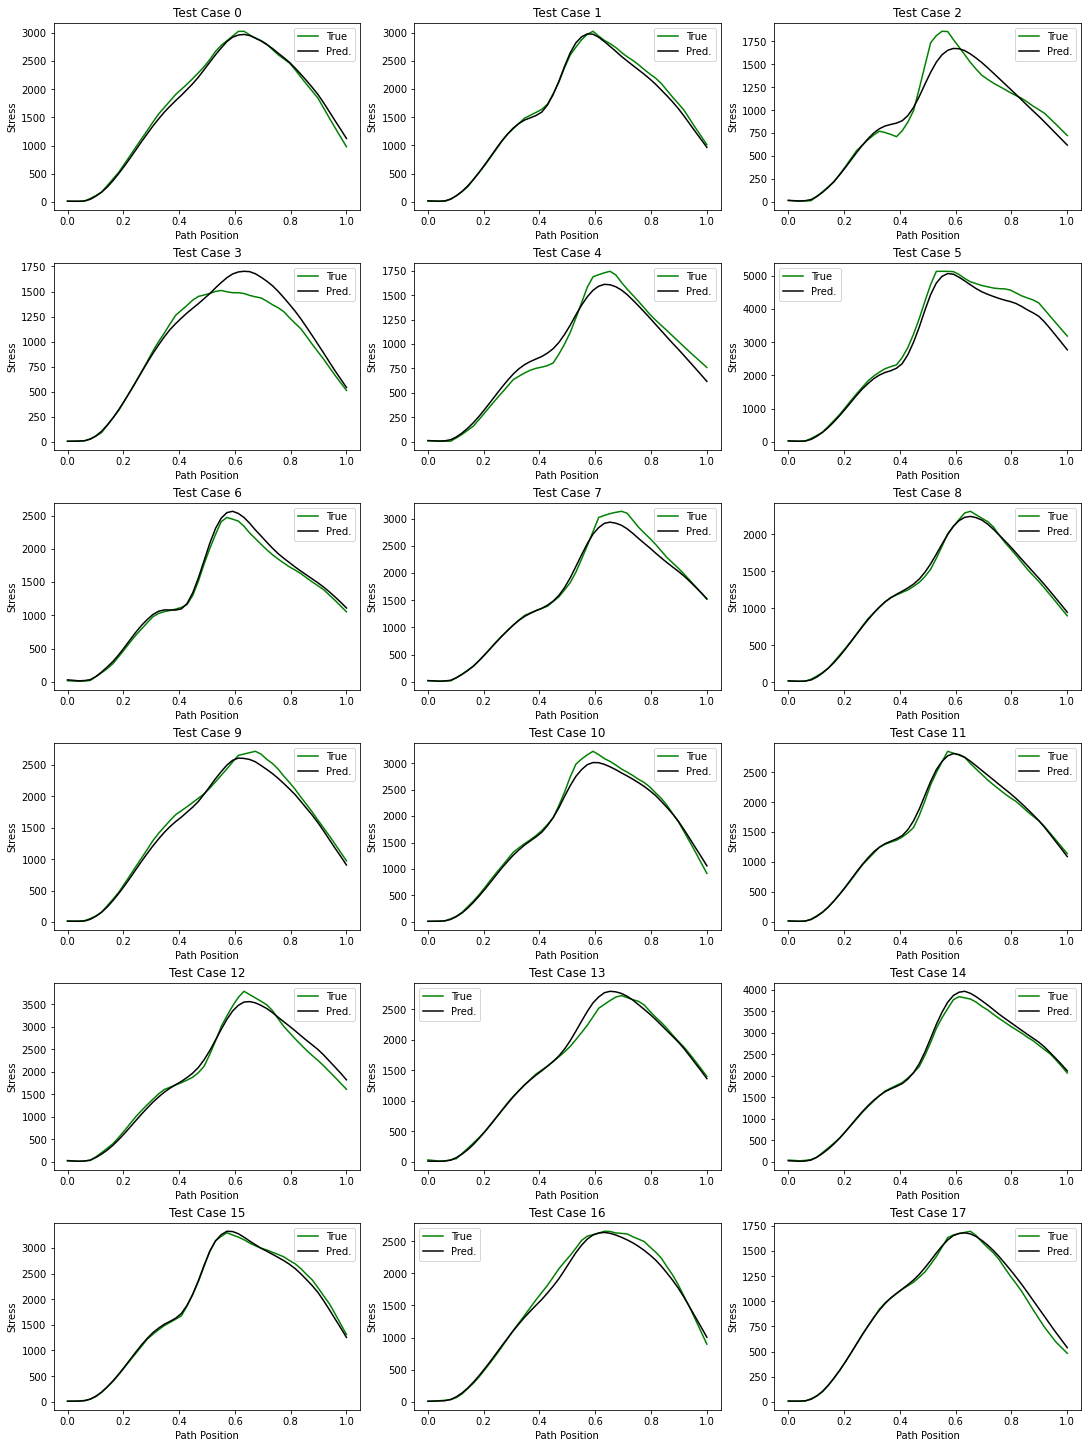

In [24]:
#Plot True and Predicted values along normalized fillet path
#Set up grid of plots
nrow=6
ncol=3

fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(15, 20), layout="constrained")

for i in range(nrow*ncol):

    l1=axs[i//3, i%3].plot(xnew, outputs_test[i], '-g', label='True')
    l2=axs[i//3, i%3].plot(xnew, predictions[i], '-k', label='Pred.')
    axs[i//3, i%3].set_xlabel('Path Position')
    axs[i//3, i%3].set_ylabel('Stress')
    axs[i//3, i%3].set_title('Test Case '+str(i))
    axs[i//3, i%3].legend()

Text(0, 0.5, 'Predicted')

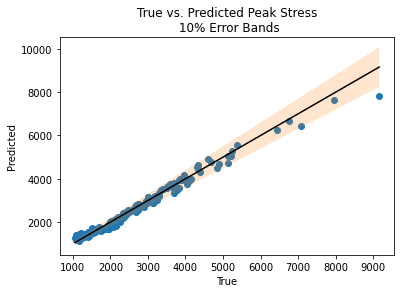

In [25]:
#Error plot
truemaxima=[]
predmaxima=[]
for i in range(predictions.shape[0]):
    truemaxima.append(outputs_test[i,:].max())
    predmaxima.append(predictions[i,:].max())
    
truemaxima=np.array(truemaxima)
predmaxima=np.array(predmaxima)

    
plt.scatter(truemaxima, predmaxima)
plt.plot([truemaxima.min(), truemaxima.max()], [truemaxima.min(), truemaxima.max()], '-k')

#Error band
err = .1
xlist=[truemaxima.min(), truemaxima.max()]
ylist_upper=[(1+err)*truemaxima.min(), (1+err)*truemaxima.max()]
ylist_lower=[(1-err)*truemaxima.min(), (1-err)*truemaxima.max()]
plt.fill_between(xlist, ylist_lower, ylist_upper, alpha=0.2)
# plt.plot(xlist, , '-g')
# plt.plot(xlist, , '-r')

plt.title('True vs. Predicted Peak Stress\n 10% Error Bands')
plt.xlabel('True')
plt.ylabel('Predicted')